# Scene Classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator generates batches of tensor image data with real-time data augmentation.

train_generator = ImageDataGenerator(
    rescale=1/255.,              # normalize pixel values between 0-1
    brightness_range=[0.1, 0.7], # specify the range in which to decrease/increase brightness
    width_shift_range=0.5,       # shift the width of the image 50%
    rotation_range=90,           # random rotation by 90 degrees
    horizontal_flip=True,        # 180 degree flip horizontally
    vertical_flip=True,          # 180 degree flip vertically
    validation_split=0.15        # 15% of the data will be used for validation at end of each epoch
)

In [ ]:
BATCH_SIZE = 256
n_epochs = 20

# flow_from_directory() takes the path to a directory & generates batches of augmented data.

train_gen = train_generator.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/scene_data/train',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               subset='training',
                                               shuffle=True,
                                               seed=42)

valid_gen = train_generator.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/scene_data/valid',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               subset='validation',
                                               shuffle=True,
                                               seed=42)

Found 11580 images belonging to 6 classes.
Found 508 images belonging to 6 classes.


## Defining The CNN Models

In [ ]:
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.regularizers import l1_l2

In [ ]:
!pip install livelossplot

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras

### Model 1 (4 CNN Layers, No Dropout)

In [ ]:
model_1 = Sequential()

model_1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(64, (3, 3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(128, (3, 3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(256, (3, 3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(512, (3, 3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Flatten())
model_1.add(Dense(1024, activation='relu'))
model_1.add(Dense(6, activation='softmax'))

# Model 1 Summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       2

### Training the Model 1

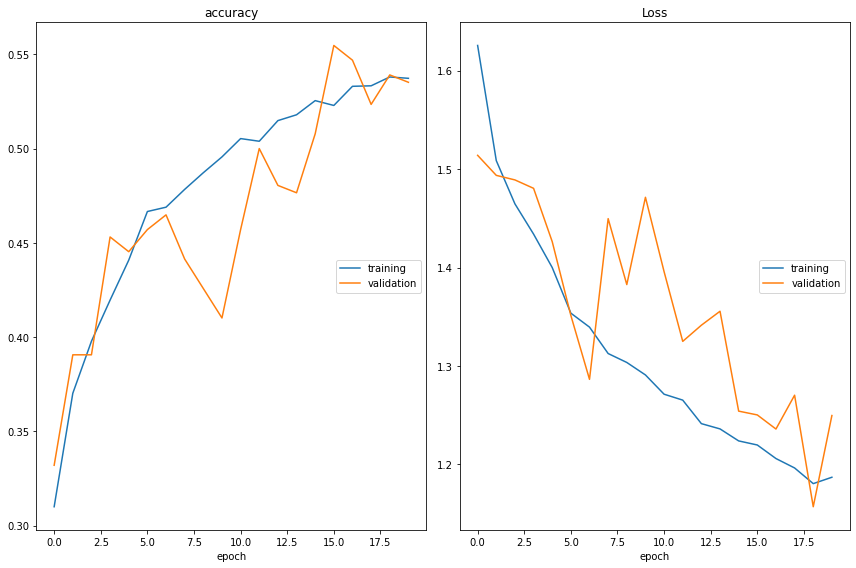

accuracy
	training         	 (min:    0.310, max:    0.538, cur:    0.537)
	validation       	 (min:    0.332, max:    0.555, cur:    0.535)
Loss
	training         	 (min:    1.181, max:    1.626, cur:    1.187)
	validation       	 (min:    1.157, max:    1.514, cur:    1.250)
CPU times: user 4h 27min 44s, sys: 3min 7s, total: 4h 30min 51s
Wall time: 2h 50min 5s


In [ ]:
%%time

steps_per_epoch = train_gen.samples // BATCH_SIZE
val_steps = valid_gen.samples // BATCH_SIZE

optimizer = RMSprop(learning_rate=0.0001)

model_1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

# Actual fitting of the model
history = model_1.fit(train_gen,
                    epochs=n_epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=valid_gen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)

### Evaluating the Model 1

In [ ]:
test_generator = ImageDataGenerator(rescale=1/255.)

test_gen = test_generator.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/scene_data/valid',
                                             target_size=(128, 128),
                                             batch_size=1,
                                             class_mode=None,
                                             shuffle=False,
                                             seed=42)

Found 3407 images belonging to 6 classes.


In [ ]:
model_1.load_weights('img_model.weights.best.hdf5')

predicted_classes = model_1.predict(test_gen)
classes = np.argmax(predicted_classes, axis=1)
predicted_classes = classes

class_indices = train_gen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = test_gen.classes

### Visualizing the Results of Model 1

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

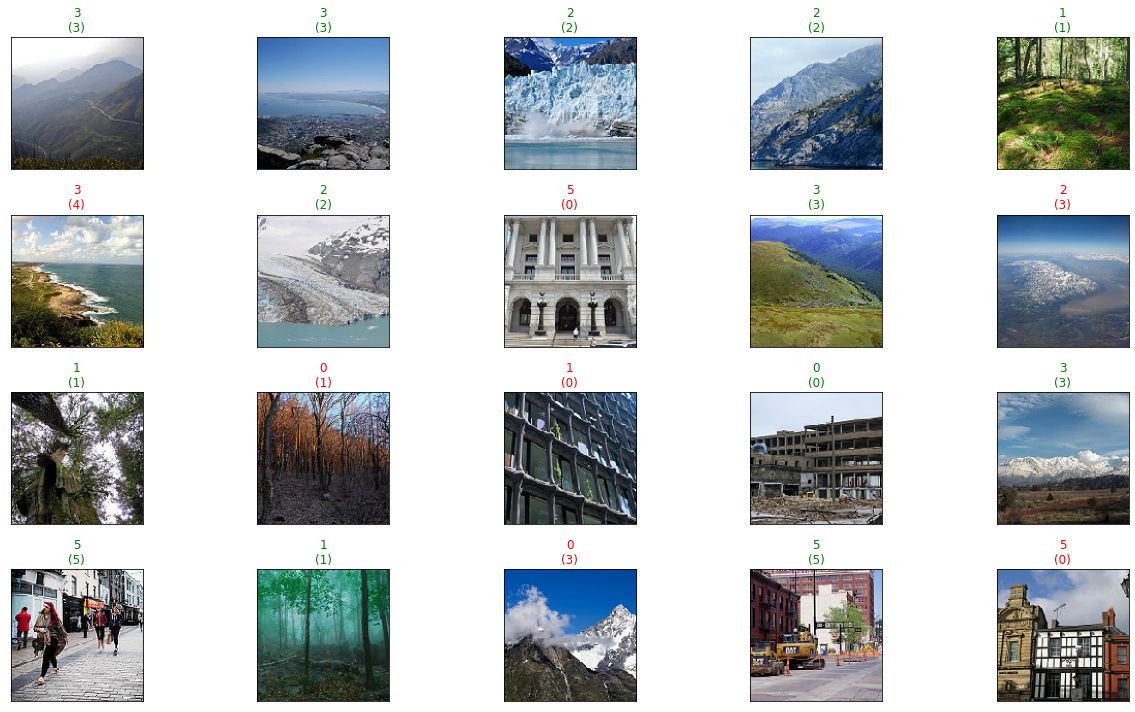

In [ ]:
plot_predictions(true_classes, predicted_classes, test_gen, class_indices)

In [ ]:
display_results(true_classes, predicted_classes, class_indices.values())

Overall Categorical Accuracy: 57.32%


Precision    Recall   F-Score  Support
1   0.809904  0.923497  0.862979    549.0
2   0.652591  0.575296  0.611511    591.0
5   0.508861  0.696707  0.588149    577.0
3   0.607422  0.512356  0.555853    607.0
0   0.351077  0.526616  0.421293    526.0
4   0.686391  0.208259  0.319559    557.0

### Model 2 (4 CNN  Layers, 0.2 Dropout, BatchNormalization)

In [ ]:
model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.20))

model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.20))

model_2.add(Conv2D(128, (3, 3), activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.20))

model_2.add(Conv2D(256, (3, 3), activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.20))

model_2.add(Conv2D(512, (3, 3), activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.20))

model_2.add(Flatten())
model_2.add(Dense(1024, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.20))
model_2.add(Dense(6, activation='softmax'))

# Model 2 Summary
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 64)       

### Training the Model 2

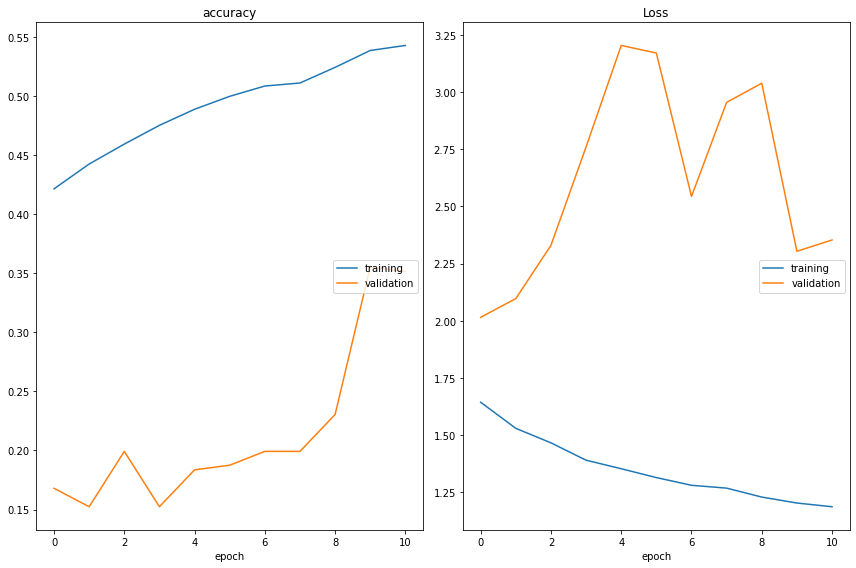

accuracy
	training         	 (min:    0.422, max:    0.543, cur:    0.543)
	validation       	 (min:    0.152, max:    0.355, cur:    0.352)
Loss
	training         	 (min:    1.186, max:    1.643, cur:    1.186)
	validation       	 (min:    2.015, max:    3.204, cur:    2.353)
CPU times: user 3h 9min 18s, sys: 2min 16s, total: 3h 11min 34s
Wall time: 1h 42min 6s


In [ ]:
%%time

steps_per_epoch = train_gen.samples // BATCH_SIZE
val_steps = valid_gen.samples // BATCH_SIZE

optimizer = RMSprop(learning_rate=0.0001)

model_2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

# Actual fitting of the model
history = model_2.fit(train_gen,
                    epochs=n_epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=valid_gen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)

### Evaluating the Model 2

In [ ]:
model_2.load_weights('img_model.weights.best.hdf5')

predicted_classes = model_2.predict(test_gen)
classes = np.argmax(predicted_classes, axis=1)
predicted_classes = classes

class_indices = train_gen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = test_gen.classes

### Visualizing the Results of Model 2

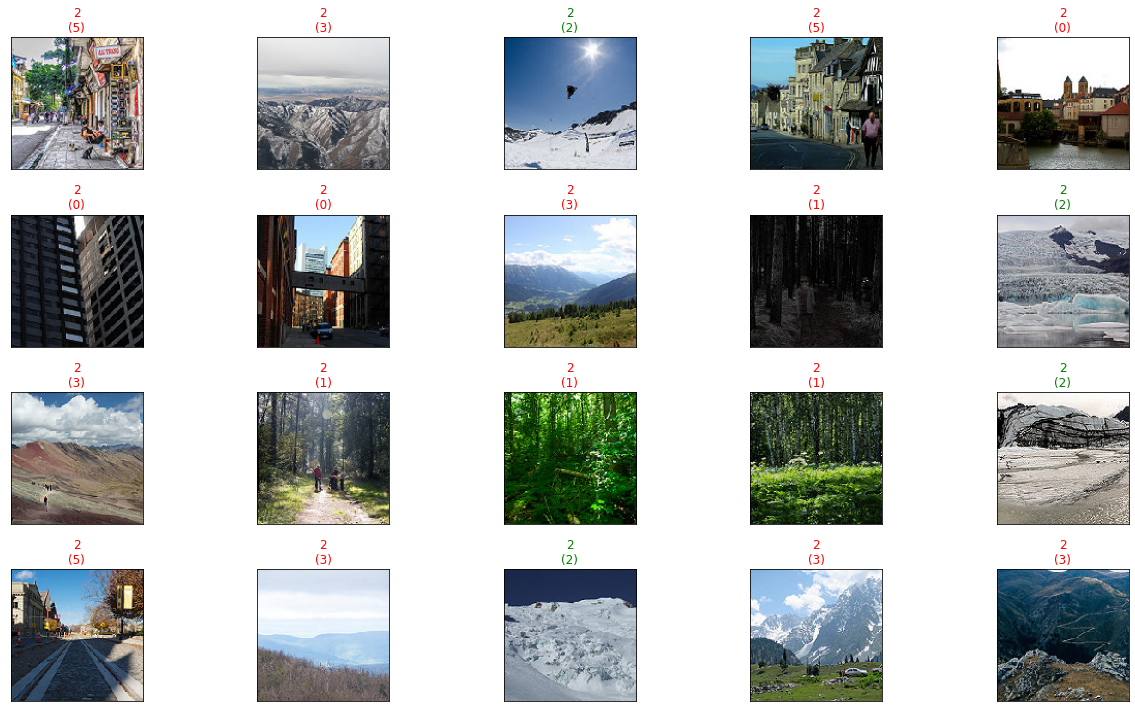

In [ ]:
plot_predictions(true_classes, predicted_classes, test_gen, class_indices)

In [ ]:
display_results(true_classes, predicted_classes, class_indices.values())

Overall Categorical Accuracy: 17.35%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision  Recall   F-Score  Support
2   0.173466     1.0  0.295648    591.0
0   0.000000     0.0  0.000000    526.0
1   0.000000     0.0  0.000000    549.0
3   0.000000     0.0  0.000000    607.0
4   0.000000     0.0  0.000000    557.0
5   0.000000     0.0  0.000000    577.0

### Model 3 (4 CNN Layers, Dropout=0.2, BatchNormalization, Glorot Uniform Initialization)

In [ ]:
from tensorflow.keras.initializers import GlorotUniform 

model_3 = Sequential()
initializer = GlorotUniform()

model_3.add(Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.20))

model_3.add(Conv2D(128, (3, 3), activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.20))

model_3.add(Conv2D(256, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.20))

model_3.add(Conv2D(512, (3, 3), activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.20))

model_3.add(Conv2D(1024, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.20))

model_3.add(Flatten())
model_3.add(Dense(128, activation='relu'))
model_3.add(Dropout(0.20))
model_3.add(Dense(64, activation='relu'))
model_3.add(Dropout(0.20))
model_3.add(Dense(32, activation='relu'))
model_3.add(Dropout(0.20))
model_3.add(Dense(16, activation='relu'))
model_3.add(Dropout(0.20))
model_3.add(Dense(6, activation='softmax', kernel_initializer=initializer))

# Model 3 Summary
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 61, 61, 128)       73856     
_________________________________________________________________
batch_normalization_10 (Batc (None, 61, 61, 128)       512       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 30, 30, 128)      

### Training the Model 3

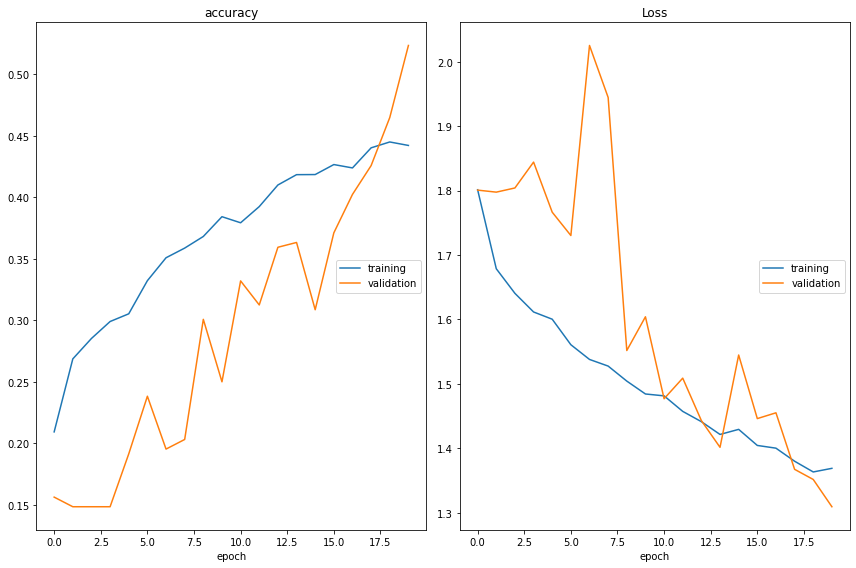

accuracy
	training         	 (min:    0.209, max:    0.445, cur:    0.442)
	validation       	 (min:    0.148, max:    0.523, cur:    0.523)
Loss
	training         	 (min:    1.363, max:    1.801, cur:    1.369)
	validation       	 (min:    1.309, max:    2.025, cur:    1.309)
CPU times: user 24min 41s, sys: 1min 16s, total: 25min 57s
Wall time: 1h 20s


In [ ]:
%%time

steps_per_epoch = train_gen.samples // BATCH_SIZE
val_steps = valid_gen.samples // BATCH_SIZE

optimizer = RMSprop(learning_rate=0.0001)

model_3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

# Actual fitting of the model
history = model_3.fit(train_gen,
                    epochs=n_epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=valid_gen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)

### Evaluating the Model 3

In [ ]:
model_3.load_weights('img_model.weights.best.hdf5')

predicted_classes = model_3.predict(test_gen)
classes = np.argmax(predicted_classes, axis=1)
predicted_classes = classes

class_indices = train_gen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = test_gen.classes

### Visualizing the Results of Model 3

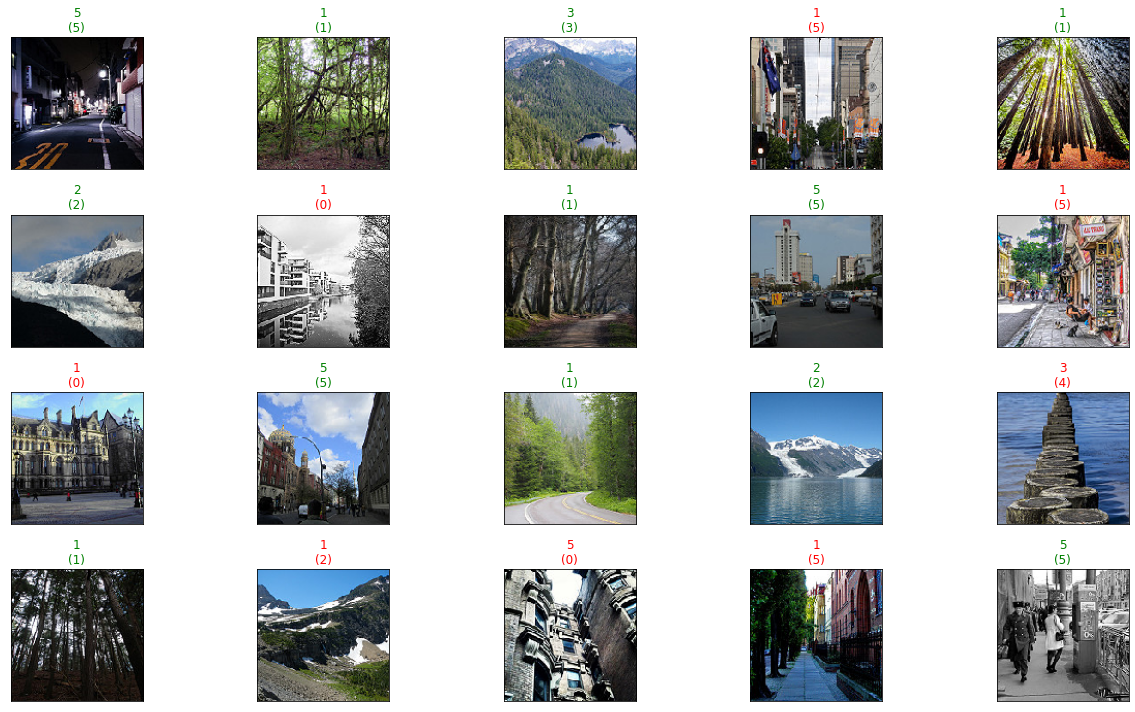

In [ ]:
plot_predictions(true_classes, predicted_classes, test_gen, class_indices)

In [ ]:
display_results(true_classes, predicted_classes, class_indices.values())

Overall Categorical Accuracy: 47.70%


Precision    Recall   F-Score  Support
2   0.582237  0.598985  0.590492    591.0
1   0.397937  0.983607  0.566632    549.0
3   0.561955  0.530478  0.545763    607.0
5   0.441931  0.507799  0.472581    577.0
4   0.613095  0.184919  0.284138    557.0
0   0.342105  0.024715  0.046099    526.0

### Model 4 (2 CNN Layers, Dropout=0.25 & 0.50, Adam Optimizer)

In [ ]:
model_4 = Sequential()

model_4.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.25))

model_4.add(Conv2D(64, (3, 3), activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.20))

model_4.add(Conv2D(128, (3, 3), activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.20))

model_4.add(Conv2D(256, (3, 3), activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.20))

model_4.add(Conv2D(512, (3, 3), activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.20))

model_4.add(Flatten())
model_4.add(Dropout(0.25))
model_4.add(Dense(64, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(6, activation='softmax'))

# Model 4 Summary
model_4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0

### Training the Model 4

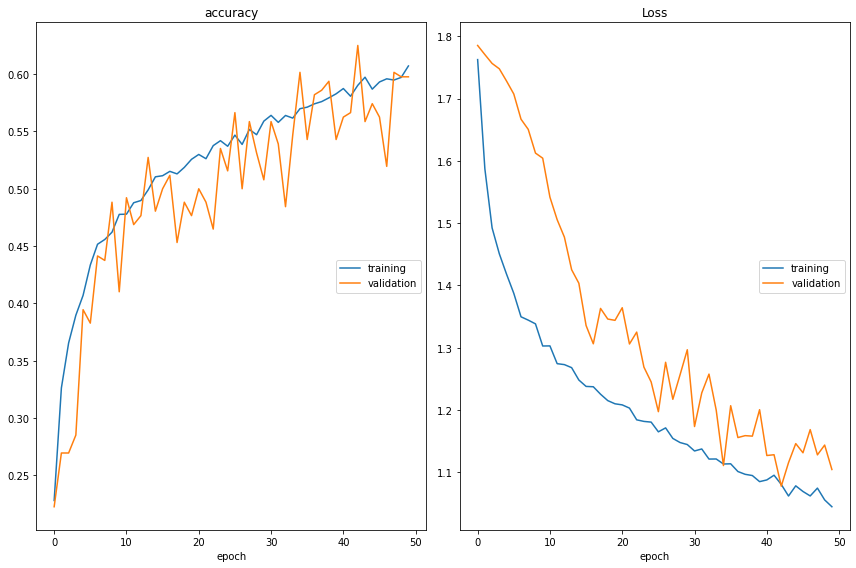

accuracy
	training         	 (min:    0.228, max:    0.607, cur:    0.607)
	validation       	 (min:    0.223, max:    0.625, cur:    0.598)
Loss
	training         	 (min:    1.045, max:    1.762, cur:    1.045)
	validation       	 (min:    1.078, max:    1.785, cur:    1.105)
CPU times: user 1h 1min 52s, sys: 3min 11s, total: 1h 5min 3s
Wall time: 2h 5min 54s


In [ ]:
%%time

import tensorflow

steps_per_epoch = train_gen.samples // BATCH_SIZE
val_steps = valid_gen.samples // BATCH_SIZE

optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)

model_4.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

# Actual fitting of the model
history = model_4.fit(train_gen,
                    epochs=50, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=valid_gen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)

### Evaluating the Model 4

In [ ]:
model_4.load_weights('img_model.weights.best.hdf5')

predicted_classes = model_4.predict(test_gen)
classes = np.argmax(predicted_classes, axis=1)
predicted_classes = classes
  
class_indices = train_gen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = test_gen.classes

### Visualizing the Results of Model 4

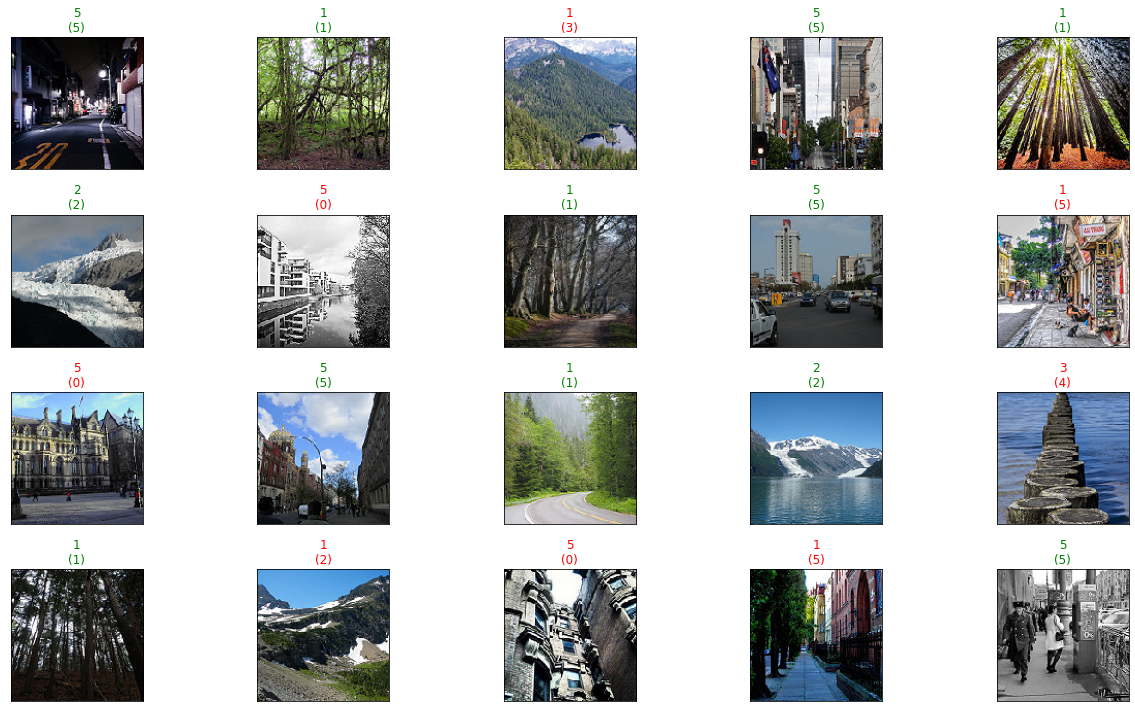

In [ ]:
plot_predictions(true_classes, predicted_classes, test_gen, class_indices)

In [ ]:
display_results(true_classes, predicted_classes, class_indices.values())

Overall Categorical Accuracy: 57.00%


Precision    Recall   F-Score  Support
1   0.518269  0.981785  0.678414    549.0
5   0.524628  0.793761  0.631724    577.0
2   0.564774  0.656514  0.607199    591.0
3   0.696697  0.382208  0.493617    607.0
4   0.687050  0.342908  0.457485    557.0
0   0.683673  0.254753  0.371191    526.0

## Conclusion

  In total 4 Models were trained and evaluated. 1st model had 4 convolutional layers without input layer and final fully connected layer and had 57.3% of categorical accuracy. Model was in good fit

  We had to increase the batch size to 256 and decreased epoches to 20 in purpose of speeding up the training
According to the evaluation results, its clear that if the batch size is decreased and no of epoches were increased, it would give more accuracy


 Second Model had 4 convolutional layers without the input layer and output layer. Also,added batch normalization to convolutional layers and dropout rate of 0.2.According to the Accuracy and Loss curves, we can say that the model was underfitting and the categorical accuracy was 17%. This models also no of epoches were 20 and batch size was 256

 Third Model had the dropout rate of 0.2 and batch normalization. Added Glorot Uniform initializer to assign weight to dense layers.When compared to Model 2, the categorical accuracy was increased but it was below the accuracy of Model 1. Still, the model was in good fit and if we could tune the hyperparameters, increase the epochs count and decrease the batch size, the model would perform well.

 For the Model 4,two dropout rates of 0.25 and 0.5 to the final layer has been added.While keeping the batch size same, the no of epochs were increased to 50. When paying attention to the curves, it is true that the model is in good fit and if we could decrease the batch size and add more epochs.Adam optimizer was used instead of rmsprop optimizer and if we could use Nadam optimizer, it may have a significant effect on the results according to the experts' openion.

 Training a dataset like this, which contains around 17,000 of images,the training time would be extremely high even though if we use GPU. Also,Batch size needed to decreased and no of epochs should be increased. The convolutional layers should be tuned carefully with the initializer, optimizers, dropout rates and dense layers. Google Colab free version has limitations and it affects negatively when training huge datasets as this